In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

In [2]:
BASE_DIR = '..'

RANDOM_SEED = 7 # for reproducibility
COUNTRIES_DIR = os.path.join(BASE_DIR, 'data', 'countries')
RESULTS_DIR = os.path.join(BASE_DIR, 'results')
FIGURES_DIR = os.path.join(BASE_DIR, 'figures')
os.makedirs(FIGURES_DIR, exist_ok=True)

In [3]:
import sys
sys.path.append(BASE_DIR)
from funcs import merge_on_lat_lon
from ridge_training import assign_groups, run_randomized_cv, run_spatial_cv

## Predict Consumption

In [4]:
def load_country(country):
    '''
    Organizes the country's dataframe so that each index corresponds to the index in the cluster features
    Returns the cluster features and the organized dataframe
    '''
    country_processed_dir = os.path.join(COUNTRIES_DIR, country, 'processed')
    country_results_dir = os.path.join(RESULTS_DIR, country, 'cnn')
    x = np.load(os.path.join(country_results_dir, 'cluster_feats.npy'))
    cluster_list = pickle.load(open(os.path.join(country_results_dir, 'cluster_order.pkl'), 'rb'))
    cluster_list = pd.DataFrame.from_records(cluster_list, columns=['cluster_lat', 'cluster_lon'])
    cluster_list['feat_index'] = np.arange(len(cluster_list))
    
    df_clusters = pd.read_csv(os.path.join(country_processed_dir, 'clusters.csv'))
    assert len(df_clusters) == len(cluster_list)

    df = merge_on_lat_lon(df_clusters, cluster_list, keys=['cluster_lat', 'cluster_lon'])
    assert len(df) == len(df_clusters) == len(cluster_list)
    df.sort_values('feat_index', ascending=True, inplace=True)
    return x, df

In [5]:
x_mw, df_mw = load_country('malawi_2016')
x_eth, df_eth = load_country('ethiopia_2016')
x_ng, df_ng = load_country('nigeria_2016')

In [6]:
y_mw = df_mw['cons_pc'].values
y_eth = df_eth['cons_pc'].values
y_ng = df_ng['cons_pc'].values

In [7]:
def test_fully_randomized_cv():
    print("Testing fully randomized CV:\n--------------\n")
    x_all = np.concatenate([x_mw, x_eth, x_ng], axis=0)
    y_all = np.concatenate([y_mw, y_eth, y_ng], axis=0)
    r2_direct, _ = run_randomized_cv(x_all, y_all, random_seed=RANDOM_SEED, to_print=False)
    r2_log, _ = run_randomized_cv(x_all, np.log(y_all), random_seed=RANDOM_SEED)
    print(f"For fully randomized cv: direct r2: {r2_direct}, log r2: {r2_log}")
    
def test_randomized_cv_per_country():
    print("Testing per country randomized CV:\n--------------\n")
    xs = [x_mw, x_eth, x_ng]
    ys = [y_mw, y_eth, y_ng]
    countries = ['malawi_2016', 'ethiopia_2016', 'nigeria_2016']
    for x, y, c in zip(xs, ys, countries):
        r2_direct, _ = run_randomized_cv(x, y, random_seed=RANDOM_SEED, to_print=False)
        r2_log, _ = run_randomized_cv(x, np.log(y), random_seed=RANDOM_SEED)
        print(f"For {c}, direct r2: {r2_direct}, log r2: {r2_log}")
    
def test_spatial_cv_per_country():
    print("Testing per country spatial CV:\n--------------\n")
    xs = [x_mw, x_eth, x_ng]
    ys = [y_mw, y_eth, y_ng]
    dfs = [df_mw, df_eth, df_ng]
    countries = ['malawi_2016', 'ethiopia_2016', 'nigeria_2016']
    for x, y, df, c in zip(xs, ys, dfs, countries):
        groups, _ = assign_groups(df, k=5, random_seed=RANDOM_SEED)
        r2_direct, _ = run_spatial_cv(x, y, groups, random_seed=RANDOM_SEED)
        r2_log, _ = run_spatial_cv(x, np.log(y), groups, random_seed=RANDOM_SEED)
        print(f"For {c}, direct r2: {r2_direct}, log r2: {r2_log}")
    
def test_cross_country_cv():
    print("Testing cross country CV:\n--------------\n")
    x_all = np.concatenate([x_mw, x_eth, x_ng], axis=0)
    y_all = np.concatenate([y_mw, y_eth, y_ng], axis=0)
    groups = np.zeros_like(y_all)
    groups[len(y_mw) : len(y_mw) + len(y_eth)] = 1 # ethiopia indices become 1
    groups[len(y_mw) + len(y_eth):] = 2 # nigeria indices become 2
    r2_direct, _ = run_spatial_cv(x_all, y_all, groups, random_seed=RANDOM_SEED, k_inner=10)
    r2_log, _ = run_spatial_cv(x_all, np.log(y_all), groups, random_seed=RANDOM_SEED, k_inner=10)
    print(f"For cross country cv: direct r2: {r2_direct}, log r2: {r2_log}")

In [12]:
# this concatenates all countries and runs randomized CV
test_fully_randomized_cv()

Testing fully randomized CV:
--------------

For fully randomized cv: direct r2: 0.3097586574652361, log r2: 0.4813238332854688


In [13]:
# this runs randomized CV per country; this is how Jean et al report their results
# we can see that the model does perform well, although how well it performs varies greatly
# in our three countries. It is difficult to make statements about why the model 
# does better in certain countries (and why predicting the log doesn't do better in ethiopia)
# without more analysis and more countries
test_randomized_cv_per_country()

Testing per country randomized CV:
--------------

For malawi_2016, direct r2: 0.2816905861235652, log r2: 0.4311725107945623
For ethiopia_2015, direct r2: 0.1545476514364329, log r2: 0.1547100665566366
For nigeria_2015, direct r2: 0.1890569012010502, log r2: 0.3670207980386114


In [14]:
# spatial CV provides very inconsistent results. this indicates that the model is 
# greatly advantaged in randomized CV, most likely because it can train on one cluster and 
# validate on a nearby cluster. this suggests there is still more to be desired for a truly generalizable model
test_spatial_cv_per_country()

Testing per country spatial CV:
--------------



/home/sk8910/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For malawi_2016, direct r2: 0.057762602604880996, log r2: 0.18602617726334478


/home/sk8910/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For ethiopia_2015, direct r2: 0.09378334585325325, log r2: 0.031192012551016224


/home/sk8910/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For nigeria_2015, direct r2: -0.07642009243968662, log r2: -0.004997054136635315


In [15]:
# the model does not generalize if trained on two countries to predict the third
# slight tweaks to this function can show how each country faired when held out
test_cross_country_cv()

Testing cross country CV:
--------------

For cross country cv: direct r2: -1.3454998935362716, log r2: -3.5210255065024465


## Plots

In [49]:
def plot_predictions(y, yhat, r2, country, max_y=None):
    if max_y is not None:
        yhat = yhat[y < max_y]
        y = y[y < max_y]
    fig = plt.figure(figsize=(8,5))
    plt.scatter(y, yhat, alpha=0.6)
    plt.plot(np.unique(y), np.poly1d(np.polyfit(y, yhat, 1))(np.unique(y)), color='g')
    plt.axvline(x=2.15, color='r', linestyle='dashed')
    plt.xlabel('Actual Consumption($/day)')
    plt.ylabel('Predicted Consumption($/day)')
    #plt.xlabel('log(Actual Consumption($/day))')
    #plt.ylabel('log(Predicted Consumption($/day))')
    plt.title(f'{country} Results ($R^2$={round(r2, 2)})')
    return fig

In [9]:
r2, yhat_mw = run_randomized_cv(x_mw, y_mw, random_seed=RANDOM_SEED, to_print=False)

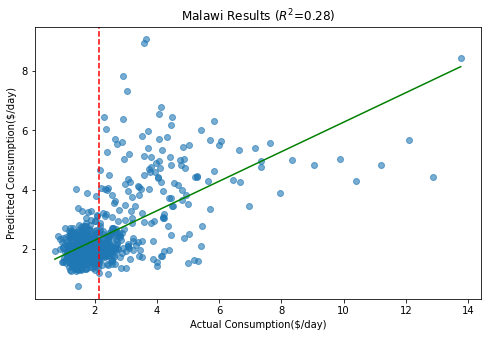

In [30]:
fig = plot_predictions(y_mw, yhat_mw, r2, 'Malawi', max_y=20)

In [ ]:
fig.savefig(os.path.join(FIGURES_DIR, 'malawi_results.png'))

In [52]:
def plot_log_predictions(y, yhat, r2, country, max_y=None):
    if max_y is not None:
        yhat = yhat[y < max_y]
        y = y[y < max_y]
    fig = plt.figure(figsize=(8,5))
    plt.scatter(y, yhat, alpha=0.6)
    plt.plot(np.unique(y), np.poly1d(np.polyfit(y, yhat, 1))(np.unique(y)), color='g')
    plt.axvline(x=np.log(2.15), color='r', linestyle='dashed')
    plt.xlabel('log(Actual Consumption($/day))')
    plt.ylabel('log(Predicted Consumption($/day))')
    plt.title(f'{country} Results ($R^2$={round(r2, 2)})')
    return fig

In [32]:
x_all = np.concatenate([x_mw, x_eth, x_ng], axis=0)
y_all = np.concatenate([y_mw, y_eth, y_ng], axis=0)
r2_direct, yhat = run_randomized_cv(x_all, y_all, random_seed=RANDOM_SEED, to_print=False)
r2_log, yhat_log = run_randomized_cv(x_all, np.log(y_all), random_seed=RANDOM_SEED)

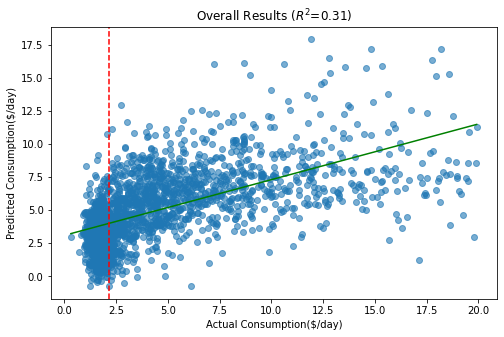

In [50]:
fig = plot_predictions(y_all, yhat, r2_direct, 'Overall', max_y=20)

In [51]:
fig.savefig(os.path.join(FIGURES_DIR, 'overall.png'))

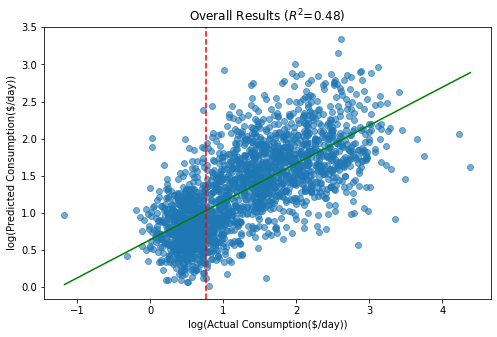

In [53]:
fig = plot_log_predictions(np.log(y_all), yhat_log, r2_log, 'Overall', max_y=20)

In [54]:
fig.savefig(os.path.join(FIGURES_DIR, 'overall_log.png'))

In [64]:
r2, yhat_mw_log = run_randomized_cv(x_mw, np.log(y_mw), random_seed=RANDOM_SEED, to_print=False)

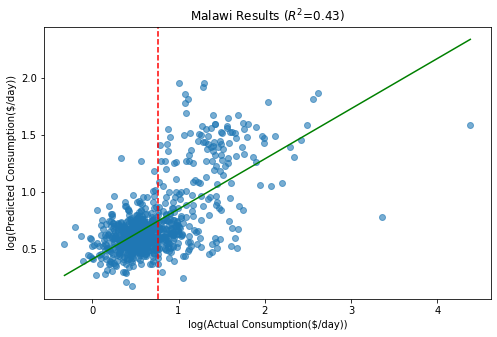

In [65]:
fig = plot_log_predictions(np.log(y_mw), yhat_mw_log, r2, 'Malawi', max_y=20)

In [66]:
fig.savefig(os.path.join(FIGURES_DIR, 'malawi_results_log.png'))

In [67]:
r2, yhat_eth = run_randomized_cv(x_eth, y_eth, random_seed=RANDOM_SEED, to_print=False)

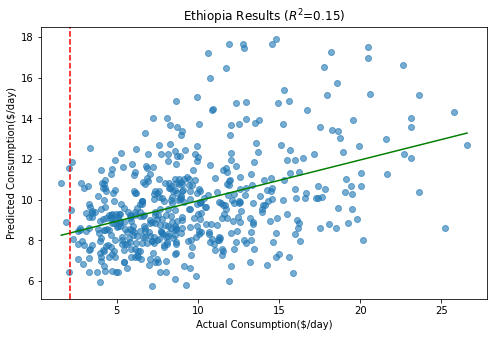

In [68]:
fig = plot_predictions(y_eth, yhat_eth, r2, 'Ethiopia', max_y=30)

In [69]:
fig.savefig(os.path.join(FIGURES_DIR, 'ethiopia_results.png'))

In [70]:
r2, yhat_eth_log = run_randomized_cv(x_eth, np.log(y_eth), random_seed=RANDOM_SEED, to_print=False)

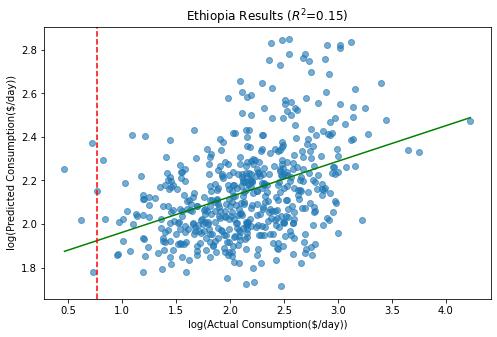

In [71]:
fig = plot_log_predictions(np.log(y_eth), yhat_eth_log, r2, 'Ethiopia', max_y=20)

In [72]:
fig.savefig(os.path.join(FIGURES_DIR, 'ethiopia_results_log.png'))

In [73]:
r2, yhat_ng = run_randomized_cv(x_ng, y_ng, random_seed=RANDOM_SEED, to_print=False)

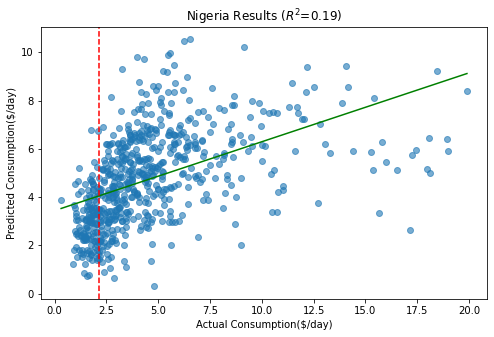

In [74]:
fig = plot_predictions(y_ng, yhat_ng, r2, 'Nigeria', max_y=20)

In [75]:
fig.savefig(os.path.join(FIGURES_DIR, 'nigeria_results.png'))

In [76]:
r2, yhat_ng_log = run_randomized_cv(x_ng, np.log(y_ng), random_seed=RANDOM_SEED, to_print=False)

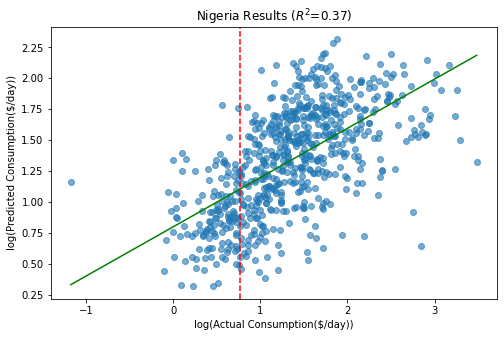

In [77]:
fig = plot_log_predictions(np.log(y_ng), yhat_ng_log, r2, 'Nigeria', max_y=20)

In [78]:
fig.savefig(os.path.join(FIGURES_DIR, 'nigeria_results_log.png'))

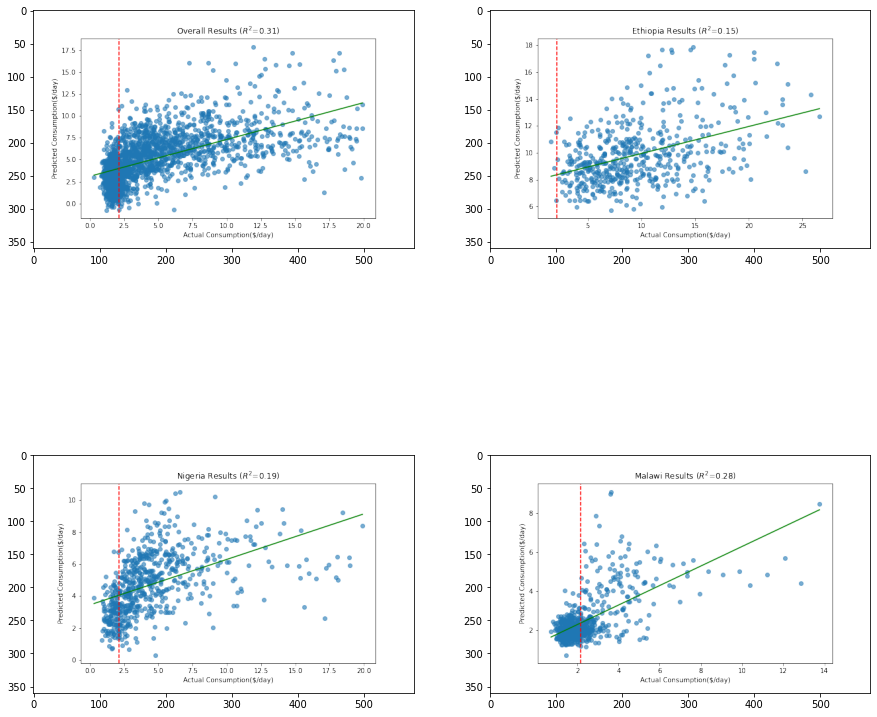

In [85]:
# Load the image files
img1 = plt.imread(os.path.join(FIGURES_DIR, 'overall.png'))
img2 = plt.imread(os.path.join(FIGURES_DIR, 'ethiopia_results.png'))
img3 = plt.imread(os.path.join(FIGURES_DIR, 'nigeria_results.png'))
img4 = plt.imread(os.path.join(FIGURES_DIR, 'malawi_results.png'))

# Create the grid of plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

# Display the images in the grid of plots
axes[0, 0].imshow(img1)
axes[0, 1].imshow(img2)
axes[1, 0].imshow(img3)
axes[1, 1].imshow(img4)

# Show the grid of plots
plt.savefig(os.path.join(FIGURES_DIR, 'results.png'))